In [1]:
library(tidyverse)
library(limma)
library(ggrepel)
library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 7)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Asian vs White

Number of differentially expressed genes (FDR < 0.05): 72 


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“ggrepel: 51 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 47 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


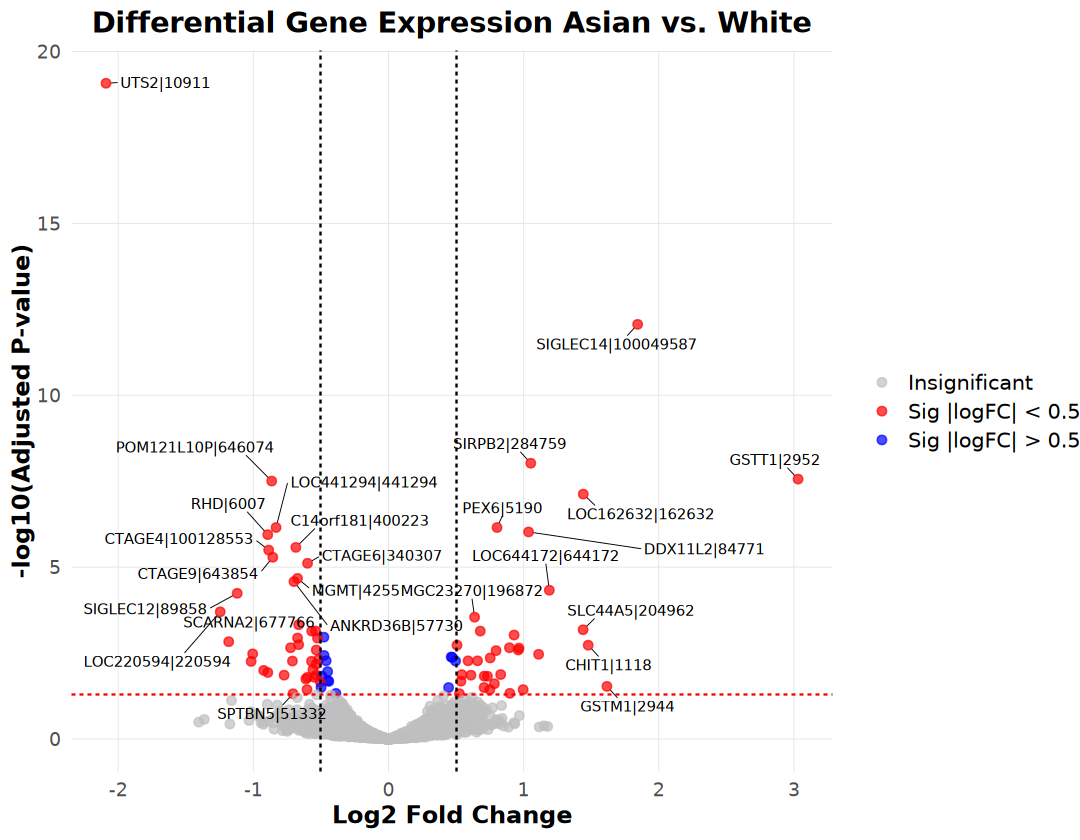

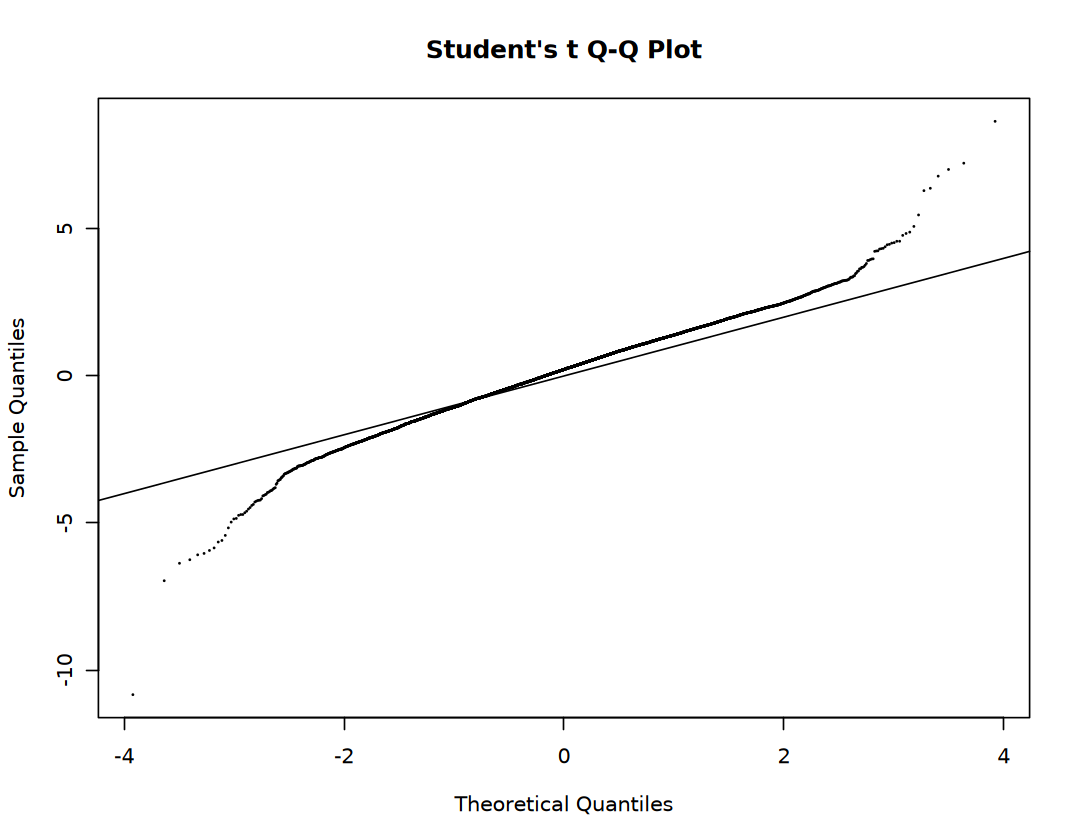

In [2]:
sample_1 = "white"
sample_2 = "asian"

white_expression <- read.csv("white_expression.csv", row.names=1, check.names=FALSE)
asian_expression <- read.csv("asian_expression.csv", row.names=1, check.names=FALSE)
expression_combined <- cbind(white_expression, asian_expression)

metadata <- data.frame(
  sample = colnames(expression_combined),
  group = c(rep(sample_1, ncol(white_expression)), rep(sample_2, ncol(asian_expression))),
  row.names = colnames(expression_combined)
)

expression_combined_log <- expression_combined
design <- model.matrix(~ 0 + group, data=metadata)
colnames(design) <- c(sample_1, sample_2)

fit <- lmFit(expression_combined_log, design)
contrast_matrix <- makeContrasts(asian_vs_white = asian - white, levels=design)
fit_contrast <- contrasts.fit(fit, contrast_matrix)
fit_contrast <- eBayes(fit_contrast)
results <- topTable(fit_contrast, coef="asian_vs_white", number=Inf, adjust.method="fdr")
results$gene <- rownames(results)
sig_genes <- results %>% filter(adj.P.Val < 0.05) %>% filter(abs(logFC) > 0.5)
cat("Number of differentially expressed genes (FDR < 0.05):", nrow(sig_genes), "\n")

# write.csv(results, "dge_results_limma.csv", row.names=FALSE)

results <- results %>%
  mutate(
    significance = case_when(
      adj.P.Val > 0.05 ~ "Insignificant",
      adj.P.Val <= 0.05 & abs(logFC) < 0.5 ~ "Significant_LowFC",
      adj.P.Val <= 0.05 & abs(logFC) > 0.5 ~ "Significant_HighFC",
      TRUE ~ "Insignificant"
    )
  )

significant_count <- results %>%
  summarise(
    low_fc = sum(significance == "Significant_LowFC", na.rm = TRUE),
    high_fc = sum(significance == "Significant_HighFC", na.rm = TRUE)
  )

colors <- c("Insignificant" = "grey", 
            "Significant_LowFC" = "blue", 
            "Significant_HighFC" = "red")

p <- ggplot(results, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = significance), size = 2, alpha = 0.7) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red", size = 0.5) +
  geom_vline(xintercept = 0.5, linetype = "dashed", color = "black", size = 0.5) +
  geom_vline(xintercept = -0.5, linetype = "dashed", color = "black", size = 0.5) +
  scale_color_manual(
    values = colors,
    labels = c("Insignificant", "Sig |logFC| < 0.5", "Sig |logFC| > 0.5")
  ) +
  geom_text_repel(
    data = filter(results, significance %in% c("Significant_HighFC")),
    aes(label = gene),
    size = 3,
    max.overlaps = 20,
    min.segment.length = 0,
    box.padding = 0.5,
    point.padding = 0.3,
    segment.color = "black",
    segment.size = 0.2
  ) +
  labs(
    x = "Log2 Fold Change",
    y = "-log10(Adjusted P-value)",
    title = "Differential Gene Expression Asian vs. White"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "right",
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.title = element_text(face = "bold"),
    panel.grid.major = element_line(color = "grey90", size = 0.2),
    panel.grid.minor = element_blank()
  )
print(p)

qqt(fit_contrast$t,df=fit_contrast$df.prior+fit_contrast$df.residual,pch=16,cex=0.2)
abline(0,1)

# Asian vs African

Number of differentially expressed genes (FDR < 0.05): 6 


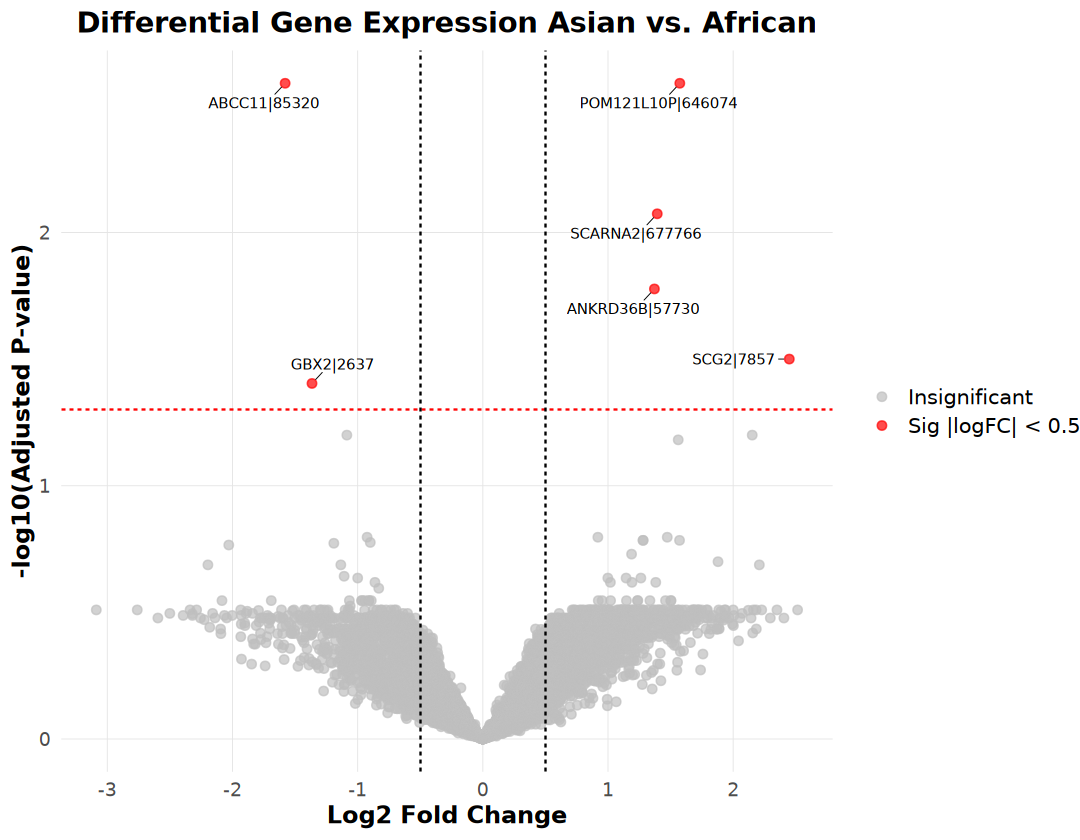

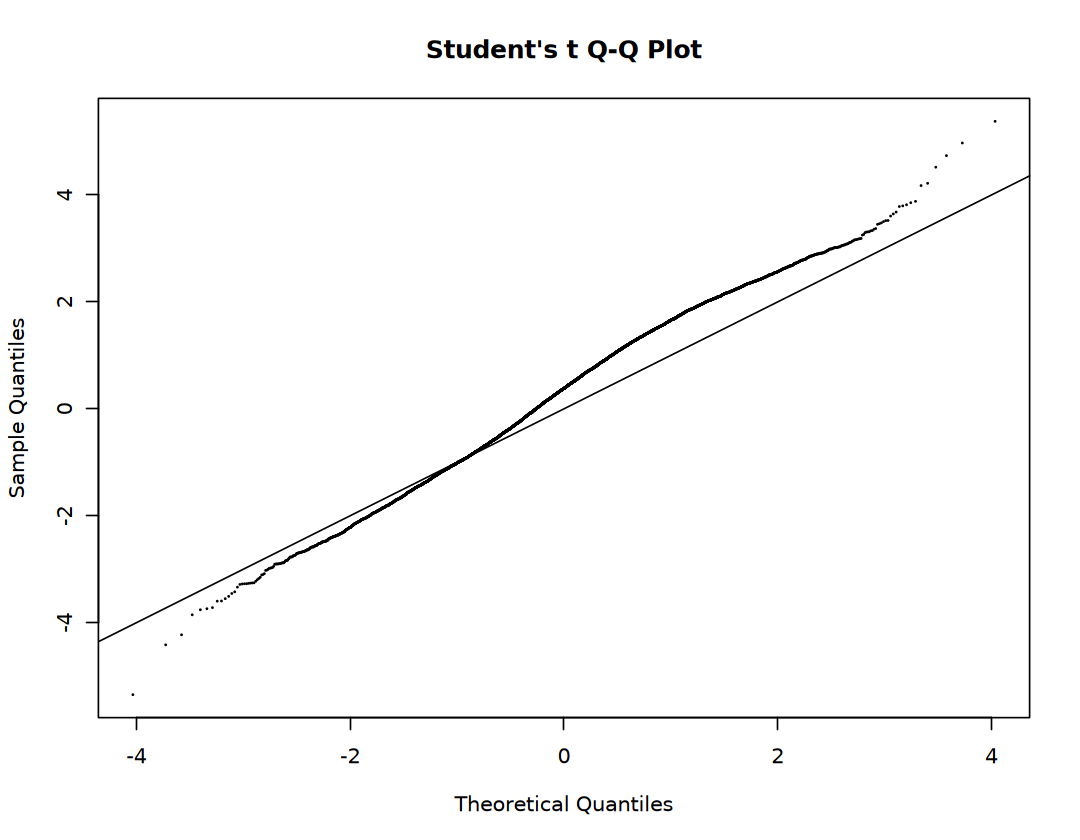

In [3]:
sample_1 = "african"
sample_2 = "asian"

white_expression <- read.csv("african_expression.csv", row.names=1, check.names=FALSE)
asian_expression <- read.csv("asian_expression.csv", row.names=1, check.names=FALSE)
expression_combined <- cbind(white_expression, asian_expression)

metadata <- data.frame(
  sample = colnames(expression_combined),
  group = c(rep(sample_1, ncol(white_expression)), rep(sample_2, ncol(asian_expression))),
  row.names = colnames(expression_combined)
)

expression_combined_log <- expression_combined
design <- model.matrix(~ 0 + group, data=metadata)
colnames(design) <- c(sample_1, sample_2)

fit <- lmFit(expression_combined_log, design)
contrast_matrix <- makeContrasts(asian_vs_african = asian - african, levels=design)
fit_contrast <- contrasts.fit(fit, contrast_matrix)
fit_contrast <- eBayes(fit_contrast)
results <- topTable(fit_contrast, coef="asian_vs_african", number=Inf, adjust.method="fdr")
results$gene <- rownames(results)
sig_genes <- results %>% filter(adj.P.Val < 0.05) %>% filter(abs(logFC) > 0.5)
cat("Number of differentially expressed genes (FDR < 0.05):", nrow(sig_genes), "\n")

# write.csv(results, "dge_results_limma.csv", row.names=FALSE)

results <- results %>%
  mutate(
    significance = case_when(
      adj.P.Val > 0.05 ~ "Insignificant",
      adj.P.Val <= 0.05 & abs(logFC) < 0.5 ~ "Significant_LowFC",
      adj.P.Val <= 0.05 & abs(logFC) > 0.5 ~ "Significant_HighFC",
      TRUE ~ "Insignificant"
    )
  )

significant_count <- results %>%
  summarise(
    low_fc = sum(significance == "Significant_LowFC", na.rm = TRUE),
    high_fc = sum(significance == "Significant_HighFC", na.rm = TRUE)
  )

colors <- c("Insignificant" = "grey", 
            "Significant_LowFC" = "blue", 
            "Significant_HighFC" = "red")

p <- ggplot(results, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = significance), size = 2, alpha = 0.7) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red", size = 0.5) +
  geom_vline(xintercept = 0.5, linetype = "dashed", color = "black", size = 0.5) +
  geom_vline(xintercept = -0.5, linetype = "dashed", color = "black", size = 0.5) +
  scale_color_manual(
    values = colors,
    labels = c("Insignificant", "Sig |logFC| < 0.5", "Sig |logFC| > 0.5")
  ) +
  geom_text_repel(
    data = filter(results, significance %in% c("Significant_HighFC")),
    aes(label = gene),
    size = 3,
    max.overlaps = 20,
    min.segment.length = 0,
    box.padding = 0.5,
    point.padding = 0.3,
    segment.color = "black",
    segment.size = 0.2
  ) +
  labs(
    x = "Log2 Fold Change",
    y = "-log10(Adjusted P-value)",
    title = "Differential Gene Expression Asian vs. African"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "right",
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.title = element_text(face = "bold"),
    panel.grid.major = element_line(color = "grey90", size = 0.2),
    panel.grid.minor = element_blank()
  )
print(p)

qqt(fit_contrast$t,df=fit_contrast$df.prior+fit_contrast$df.residual,pch=16,cex=0.2)
abline(0,1)

# UMAP group1 and group2

Number of differentially expressed genes (FDR < 0.05): 2369 


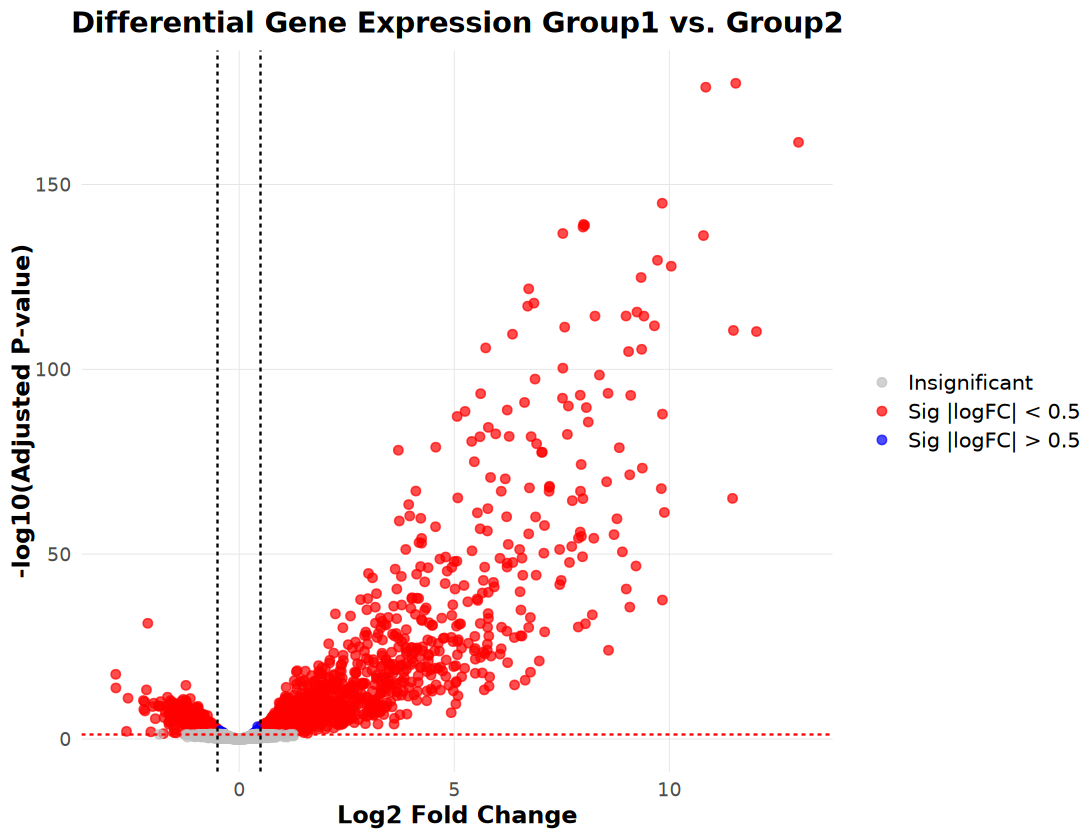

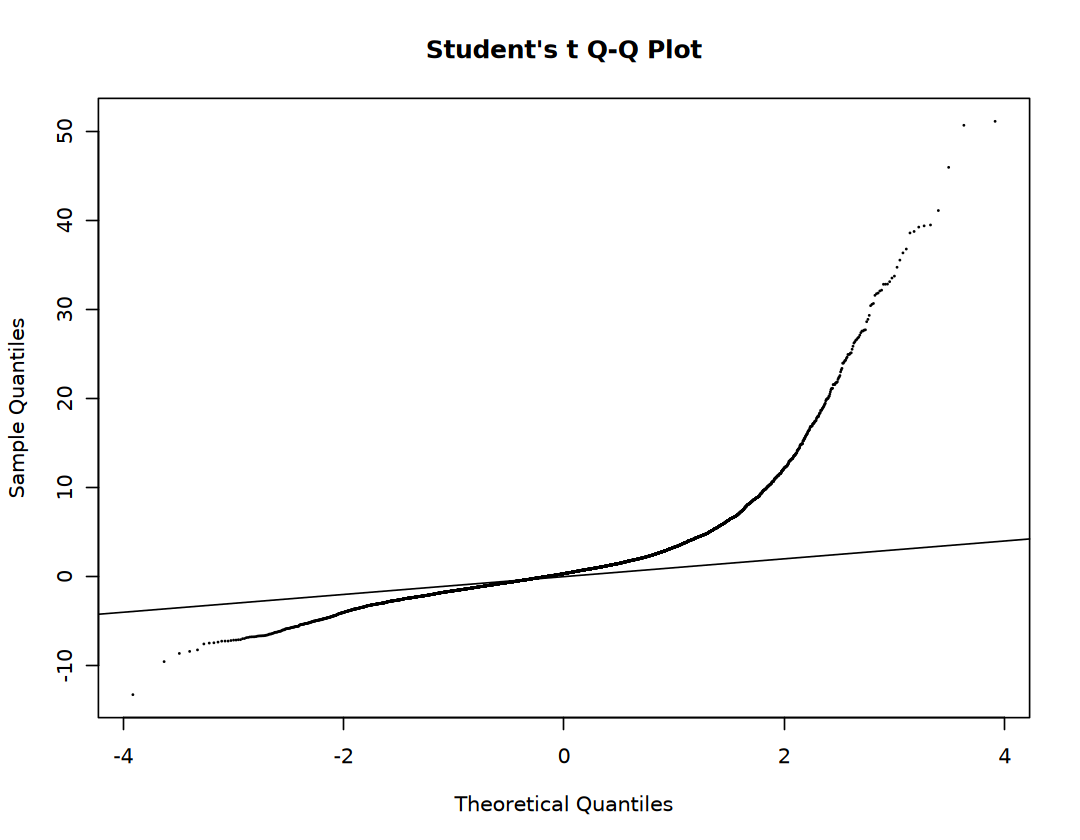

In [4]:
sample_1 = "group1"
sample_2 = "group2"

white_expression <- read.csv("group1_expression.csv", row.names=1, check.names=FALSE)
asian_expression <- read.csv("group2_expression.csv", row.names=1, check.names=FALSE)
expression_combined <- cbind(white_expression, asian_expression)

metadata <- data.frame(
  sample = colnames(expression_combined),
  group = c(rep(sample_1, ncol(white_expression)), rep(sample_2, ncol(asian_expression))),
  row.names = colnames(expression_combined)
)

expression_combined_log <- expression_combined
design <- model.matrix(~ 0 + group, data=metadata)
colnames(design) <- c(sample_1, sample_2)

fit <- lmFit(expression_combined_log, design)
contrast_matrix <- makeContrasts(group1_vs_group2 = group1 - group2, levels=design)
fit_contrast <- contrasts.fit(fit, contrast_matrix)
fit_contrast <- eBayes(fit_contrast)
results <- topTable(fit_contrast, coef="group1_vs_group2", number=Inf, adjust.method="fdr")
results$gene <- rownames(results)
sig_genes <- results %>% filter(adj.P.Val < 0.05) %>% filter(abs(logFC) > 0.5)
cat("Number of differentially expressed genes (FDR < 0.05):", nrow(sig_genes), "\n")

# write.csv(results, "dge_results_limma.csv", row.names=FALSE)

results <- results %>%
  mutate(
    significance = case_when(
      adj.P.Val > 0.05 ~ "Insignificant",
      adj.P.Val <= 0.05 & abs(logFC) < 0.5 ~ "Significant_LowFC",
      adj.P.Val <= 0.05 & abs(logFC) > 0.5 ~ "Significant_HighFC",
      TRUE ~ "Insignificant"
    )
  )

significant_count <- results %>%
  summarise(
    low_fc = sum(significance == "Significant_LowFC", na.rm = TRUE),
    high_fc = sum(significance == "Significant_HighFC", na.rm = TRUE)
  )

colors <- c("Insignificant" = "grey", 
            "Significant_LowFC" = "blue", 
            "Significant_HighFC" = "red")

p <- ggplot(results, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = significance), size = 2, alpha = 0.7) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red", size = 0.5) +
  geom_vline(xintercept = 0.5, linetype = "dashed", color = "black", size = 0.5) +
  geom_vline(xintercept = -0.5, linetype = "dashed", color = "black", size = 0.5) +
  scale_color_manual(
    values = colors,
    labels = c("Insignificant", "Sig |logFC| < 0.5", "Sig |logFC| > 0.5")
  ) +
  labs(
    x = "Log2 Fold Change",
    y = "-log10(Adjusted P-value)",
    title = "Differential Gene Expression Group1 vs. Group2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "right",
    legend.title = element_blank(),
    legend.text = element_text(size = 12),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.title = element_text(face = "bold"),
    panel.grid.major = element_line(color = "grey90", size = 0.2),
    panel.grid.minor = element_blank()
  )
print(p)

qqt(fit_contrast$t,df=fit_contrast$df.prior+fit_contrast$df.residual,pch=16,cex=0.2)
abline(0,1)